In [13]:
import os, sys, gc, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import itertools
import seaborn as sns

from frontiers_colors import get_color
from frontiers_analysis import heaps, load_tissue, save_model, mazzolini, load_all_data

from tableanalyser import plotvarmen, plotcv2mean
from tacos_plot import scatterdense

In [18]:
%load_ext watermark
%watermark -v -m  -u È-n -p pandas,numpy,scipy,matplotlib,seaborn -a Filippo_Valle -g -r -b -w

Filippo_Valle 
last updated: Mon Mar 30 2020 

CPython 3.7.6
IPython 7.13.0

pandas 1.0.2
numpy 1.18.1
scipy 1.4.1
matplotlib 3.1.3
seaborn 0.10.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   : aea6f0f5e1dbc05ebce69c97aa66a526762459eb
Git repo   : git@github.com:SilviaLazzardi/Frontiers_plots_tm.git
Git branch : develop
watermark 2.0.2


# Load Data

Choose one of these data source:
* mca for Mouse Cell Atlas (default)
* tm for Tabula Muris
* gtex for GTex

For Mouse Cell Atlas data will be automatically downloaded!

In [31]:
data_source = "mca"
os.system(f"mkdir -p {data_source}")
files = os.listdir(data_source)

In [8]:
# Download all the files for MCA
from frontiers_analysis import get_files
get_files()

.ipynb_checkpoints
data
GSE108097-GPL17021_series_matrix.txt
GSM2889480_Bladder_dge.txt


Please download the following files from original dataset
[https://figshare.com/s/865e694ad06d5857db4b](https://figshare.com/s/865e694ad06d5857db4b):
* *MCA_Figure2_Cell.Info.xlsx*
* *MCA_CellAssignments.csv*

They are required before run the following cells

In [5]:
df_info = pd.read_excel("MCA_Figure2_Cell.Info.xlsx", index_col=0)

df_info['Tissue'] = list(map(lambda ann: ann.replace("Adult",""), df_info['Tissue'])) #remove adult or fetal
df_info['Tissue'] = list(map(lambda ann: ann.replace("Fetal",""), df_info['Tissue'])) #remove adult or fetal
df_info['Tissue'] = list(map(lambda ann: ann.replace("Neonatal",""), df_info['Tissue'])) #remove adult or fetal
df_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61637 entries, Uterus_1.CTGTGTAAGTACAGGGTC to Bladder_1.AGTTTATTTAGGGAGGAG
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ClusterID  61637 non-null  int64 
 1   Tissue     61637 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [37]:
df_file=pd.read_csv("MCA_CellAssignments.csv", index_col=0).set_index('Cell.name')
df_file['Cell_type'] = list(map(lambda ann: ann.split('(')[0].split(' ')[0], df_file['Annotation'])) #remove adult or fetal
df_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270848 entries, Bladder_1.AAAACGAAAACGGGGCGA to NeonatalPancreas_1.GCTCAAATACAGATACAG
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ClusterID     270848 non-null  object
 1   Tissue        270848 non-null  object
 2   Batch         270848 non-null  object
 3   Cell.Barcode  270848 non-null  object
 4   Annotation    270848 non-null  object
 5   Cell_type     270848 non-null  object
dtypes: object(6)
memory usage: 14.5+ MB


In [7]:
df_info = df_file
df_info["id"] = df_file.index.values
df_info.rename(columns={'Tissue':'tissue',"id": "Cell_id"}, inplace=True)
df_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 270848 entries, Bladder_1.AAAACGAAAACGGGGCGA to NeonatalPancreas_1.GCTCAAATACAGATACAG
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ClusterID     270848 non-null  object
 1   tissue        270848 non-null  object
 2   Batch         270848 non-null  object
 3   Cell.Barcode  270848 non-null  object
 4   Annotation    270848 non-null  object
 5   Cell_type     270848 non-null  object
 6   Cell_id       270848 non-null  object
dtypes: object(7)
memory usage: 16.5+ MB


In [36]:
files = list(filter(lambda f: "dge" in f,  os.listdir(data_source)))
files

['GSM2889480_Bladder_dge.txt',
 'GSM2889481_Prostate1_dge.txt',
 'GSM2889482_Prostate2_dge.txt',
 'GSM2889483_MammaryGland.Involution1_dge.txt',
 'GSM2889484_MammaryGland.Involution2_dge.txt',
 'GSM2906396_BoneMarrow1_dge.txt',
 'GSM2906399_BoneMarrow2_dge.txt.gz',
 'GSM2906400_BoneMarrow3_dge.txt',
 'GSM2906401_BoneMarrowcKit1_dge.txt',
 'GSM2906402_BoneMarrowcKit2_dge.txt',
 'GSM2906403_BoneMarrowcKit3_dge.txt',
 'GSM2906404_Bone.Marrow.Mesenchyme_dge.txt',
 'GSM2906405_Brain1_dge.txt',
 'GSM2906406_Brain2_dge.txt.gz',
 'GSM2906407_CJ7.EB14.Ezh2.1_dge.txt',
 'GSM2906408_CJ7.EB14.WT.1_dge.txt',
 'GSM2906409_CJ7.EB14.WT.2_dge.txt.gz',
 'GSM2906410_EB.Ezh2_dge.txt',
 'GSM2906411_EB.WT_dge.txt',
 'GSM2906412_EmbryonicMesenchymeE14.5_dge.txt',
 'GSM2906413_EmbryonicStemCell_dge.txt',
 'GSM2906414_EmbryonicStemCell.CJ7_dge.txt',
 'GSM2906415_FetalBrain_dge.txt',
 'GSM2906416_FetalFemaleGonad_dge.txt.gz',
 'GSM2906417_FetalIntestine_dge.txt',
 'GSM2906418_FetalKidney1_dge.txt',
 'GSM2906419

# Analyse organs and store data
Here some files with all the analyses will be stored, this take a long time.

In [ ]:
print(files[0])

saved = []
frac_of = {}

if "mca" in data_source:
    data = pd.read_csv(f"{data_source}/{files[0]}", sep=" ")
    data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

    #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
    tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

if "tm" in data_source:
    tissues = [files[0]]


print(tissues)
for tissue in tissues:
    if "mca" in data_source:
        df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
    
    if "tm" in data_source:
        df = pd.read_csv(f"{data_source}/{files[0]}", sep=",", index_col=0) #tabula muris
        df = clean_df(df) #tabula muris
    
    A = df.sum(axis=1)
    O = df.apply(lambda x: len(x[x>0]), 1)
    M = df.apply(np.sum, 0)
    cell_zeros = df.astype(int).apply(lambda x: len(x[x==0]), 0)
    gene_presence = df.apply(lambda x: len(x[~x.isna()]), 1).astype(int)
    gene_presence_nonnull = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
    var = df.apply(lambda x: (x*x).sum(), 1)
    
    frac_of[tissue] = {'data': A,
                            'N': len(M)}
    
    diffWords = df.apply(lambda x: len(x[x>0]), 0)
    n_genes = {}
    n_genes[tissue] = diffWords
    
    n_expressed_genes = pd.Series(index=df.index, data=np.zeros_like(df.index))
    n_expressed_genes[A.sort_values(ascending=False).index[:100]]+=1
    save_model(df, "data", tissue)
    mazzolini(M, A/A.sum(), tissue)
    #heaps(M, diffWords, tissue)
    
    saved.append(tissue)
    df.to_csv(f"{data_source}/mainTable_{tissue}.csv", index=True, header=True)

In [ ]:
for file in files[1:]:
    print(file)
    if "mca" in data_source:
        data = pd.read_csv(f"{data_source}/{file}", sep=" ")
        data = data[data.columns[data.columns.isin(df_info['Cell_id'])]]

        if len(data.columns) < 1:
            print(f"skipping {file} \n")
            continue
        #tissues = df_info[df_info['Cell_id'].isin(data.columns) & (df_info['Development_stage']=='Adult')]['tissue'].unique() # only adults
        tissues = df_info[df_info['Cell_id'].isin(data.columns)]['tissue'].unique()

    if "tm" in data_source:
        data = pd.read_csv(f"{data_source}/{file}", sep=",", index_col=0)
        tissues = [files[0]]
    
    print(tissues)
    if len(tissues) < 1:
        print(f"no tissue found \n")
        continue
    for tissue in tissues:
        
        if "mca" in data_source:
            df = data.reindex(columns=df_info[df_info['Cell_id'].isin(data.columns) & (df_info['tissue']==tissue)]['Cell_id'])
        
        if "tm" in data_source:
            df = clean_df(data)
        
        if tissue in saved:
            df = df.transpose().append(pd.read_csv(f"{data_source}/mainTable_{tissue}.csv", index_col=0, header=0).transpose(), ignore_index=False, sort=True).transpose().fillna(0)
        
        #df = df.divide(df.sum(0), 1).applymap(lambda cpm: np.log(cpm*1e6+1)) #log(cpm +1)
        A_sub = df.sum(axis=1)
        O_sub = df.apply(lambda x: len(x[x>0]), 1)
        M_sub = df.apply(np.sum, 0)
        cell_zeros_sub = df.apply(lambda x: len(x[x>0]), 0)
        diffWords_sub = df.apply(lambda x: len(x[x>0]), 0)
        
        if tissue in frac_of.keys():
            frac_of[tissue]['data'].add(A_sub, fill_value = 0)
            frac_of[tissue]['N']+=len(M_sub)
        else:
            frac_of[tissue] = {'data': A_sub,
                                  'N': len(M_sub)}

        A = A.add(A_sub, fill_value=0)
        O = O.add(O_sub, fill_value=0)
        M = M.append(M_sub)
        cell_zeros = cell_zeros.append(cell_zeros_sub)
        diffWords = diffWords.append(diffWords_sub)
        if tissue in n_genes.keys():
            n_genes[tissue] = n_genes[tissue].append(diffWords_sub)
        else:
            n_genes[tissue]= diffWords_sub
        
        gene_presence = gene_presence.add(df.apply(lambda x: len(x[~x.isna()]), 1), fill_value=0)
        gene_presence_nonnull_sub = df.apply(lambda x: len(x[~x.isna() & (x>0)]), 1).astype(int)
        gene_presence_nonnull = gene_presence_nonnull.add(gene_presence_nonnull_sub, fill_value=0).astype(int)
        var = var.add(df.apply(lambda x: (x*x).sum(), 1), fill_value=0)
        
        n_expressed_genes_sub = pd.Series(index=df.index, data=np.zeros_like(df.index))
        n_expressed_genes_sub[A_sub.sort_values(ascending=False).index[:100]]+=1
        n_expressed_genes = n_expressed_genes.add(n_expressed_genes_sub, fill_value=0)

        save_model(df,"data",tissue)
        mazzolini(M_sub, A_sub/A_sub.sum(), tissue)
        #heaps(M_sub, diffWords_sub, tissue)
        saved.append(tissue)
        df.to_csv(f"{data_source}/mainTable_{tissue}.csv", index=True, header=True)
        print(f"Handling {len(M)} cells")

        del df 
        del A_sub
        del O_sub
        del M_sub
        del diffWords_sub
        del gene_presence_nonnull_sub
        gc.collect()
        print("\n")
    del tissues
    del data
    gc.collect()

means = A/gene_presence
means_nozero = A/gene_presence_nonnull
var = var/gene_presence - means*means
f = (A/A.sum())
O = O / gene_presence
O = O.reindex_like(means)
cv2 = var/means/means


print("Saving data.pkl")
data = {
    'means': means,
    'var': var,
    'freq': A/A.sum(),
    'O': O,
    'M': M,
    'cv2': cv2,
    'diffWords': diffWords,
    'means_nonzero': means_nozero,
    'n_expressed': n_expressed_genes,
    'n_genes': n_genes,
    'frac_of': frac_of,
    'cell_zeros': cell_zeros
}

with open("data_all.pkl","wb") as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

### Load already done analyses

In [17]:
data = load_all_data("mca")

# Correlations with Tabula Muris

In [11]:
common_organs = ["Bladder", "Kidney", "Liver", "Lung", "Pancreas", "Spleen"]

In [14]:
tm = load_all_data("tm")["freq"]
mca = load_all_data("mca")["freq"]
tm = tm[tm.index.isin(mca.index)]
mca = mca[mca.index.isin(tm.index)]
tm = pd.Series(name='tm',index=tm.sort_values(ascending=False).index, data=range(1,1+len(tm)))
mca = pd.Series(name='mca',index=mca.sort_values(ascending=False).index, data=range(1, len(mca)+1))

mca = mca.reindex_like(tm).dropna()

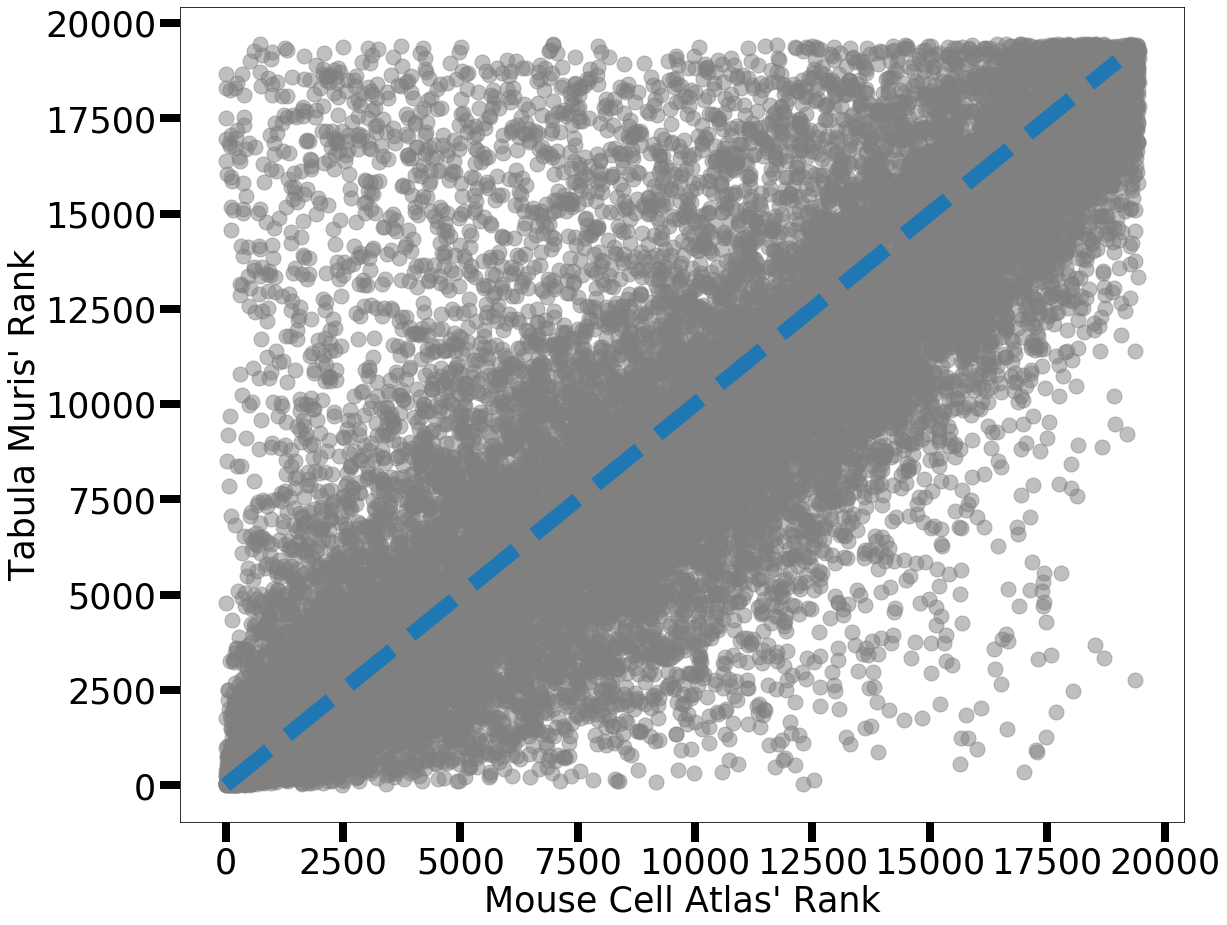

In [15]:
fig, ax = plt.subplots(figsize=(18,15))
ax.scatter(mca.values,tm.values, c="gray", s=225, alpha=0.5)

ax.plot(np.linspace(0,1.9e4), np.linspace(0,1.9e4), lw=15, ls="--")

ax.set_xlabel("Mouse Cell Atlas' Rank", fontsize=35)
ax.set_ylabel("Tabula Muris' Rank", fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)

fig.savefig("rank_correlation.pdf")
plt.show()

# Fraction of trascriptome described

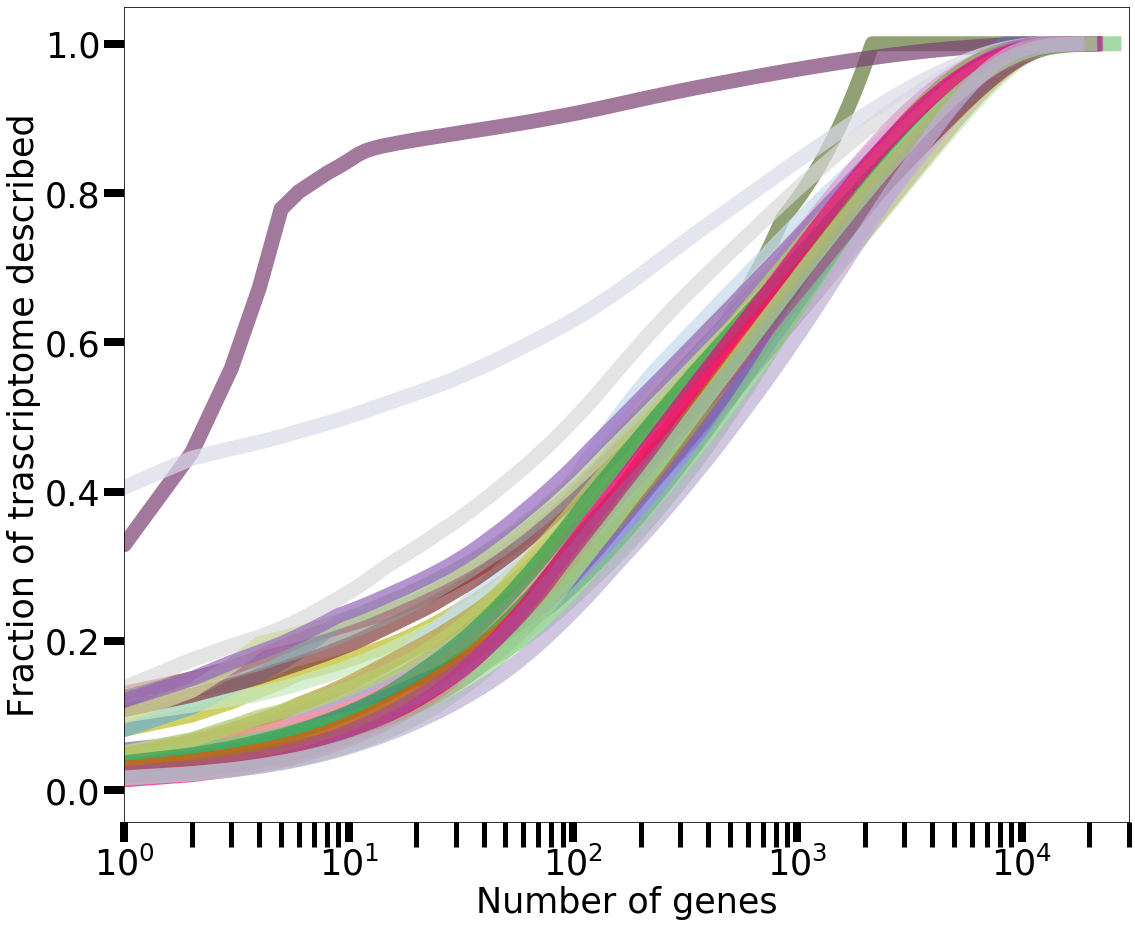

In [41]:
thresholded = {}

frac_of = data["frac_of"]

fig,ax = plt.subplots(figsize=(18,15))
for tissue in frac_of.keys():
    #if "Lactation" in tissue:
    #    continue
    A_tissue = (frac_of[tissue]['data'] / frac_of[tissue]['N']).sort_values(ascending=False)
    A_tissue_sum = np.cumsum(A_tissue.values) / A_tissue.sum() #h thr
    ax.plot(A_tissue_sum, label = tissue, c=get_color(tissue), lw=15, alpha=.7)
    #if len(A_tissue_sum) < 2:
    #    continue
    thresholded[tissue] = A_tissue_sum[99]
    #thresholded[tissue] = np.argwhere(A_tissue_sum>=0.4).ravel()[0] #v thr
ax.set_xscale('log')
ax.set_xlim(1, 3e4)
ax.set_xlabel("Number of genes", fontsize=35)
ax.set_ylabel("Fraction of trascriptome described", fontsize=35)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
fig.savefig("fracof_mca.pdf")

# All Tissues

## Zipf

<class 'FileNotFoundError'> [Errno 2] No such file or directory: 'mca/data_Fetal_Kidney_data.pkl' <traceback object at 0x7ff2ee004550>


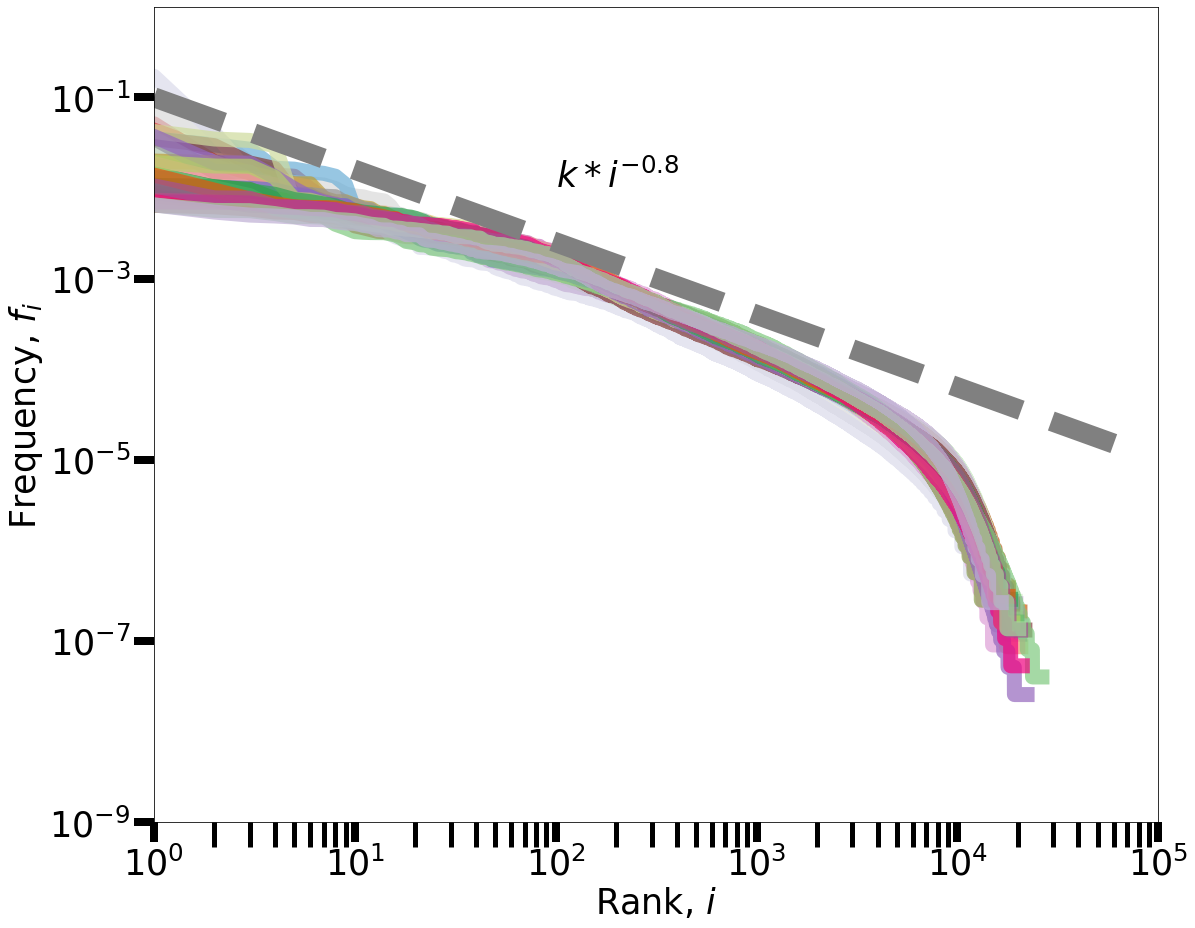

In [40]:
fig, ax = plt.subplots(figsize=(18,15))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue 
    if "Lactation" in tissue:
        continue
    f = info["freq"]
    ax.plot(f.sort_values(ascending=False).values, label=tissue, c=get_color(tissue), lw=15, alpha=.7)
    
x =np.linspace(1,6e4,10)

exp = 0.8
ax.plot(x, 1e-1*np.power(x, -0.8), lw=20, c='gray', ls='--')

ax.set_xscale("log")
ax.set_yscale("log")

ax.annotate('$k*i^{-%.1f}$'%exp, (1e2,1e-2), fontsize=35)

# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)

ax.set_xlim(1,1e5)
ax.set_ylim(1e-9,1e0)
ax.set_xlabel("Rank, $i$", fontsize=35)
ax.set_ylabel("Frequency, $f_i$", fontsize=35)

plt.show()
fig.savefig(f"zipf_alltissue_{data_source}.pdf")

## Heaps

<class 'FileNotFoundError'> [Errno 2] No such file or directory: 'mca/data_Fetal_Kidney_data.pkl' <traceback object at 0x7ff3024efc80>


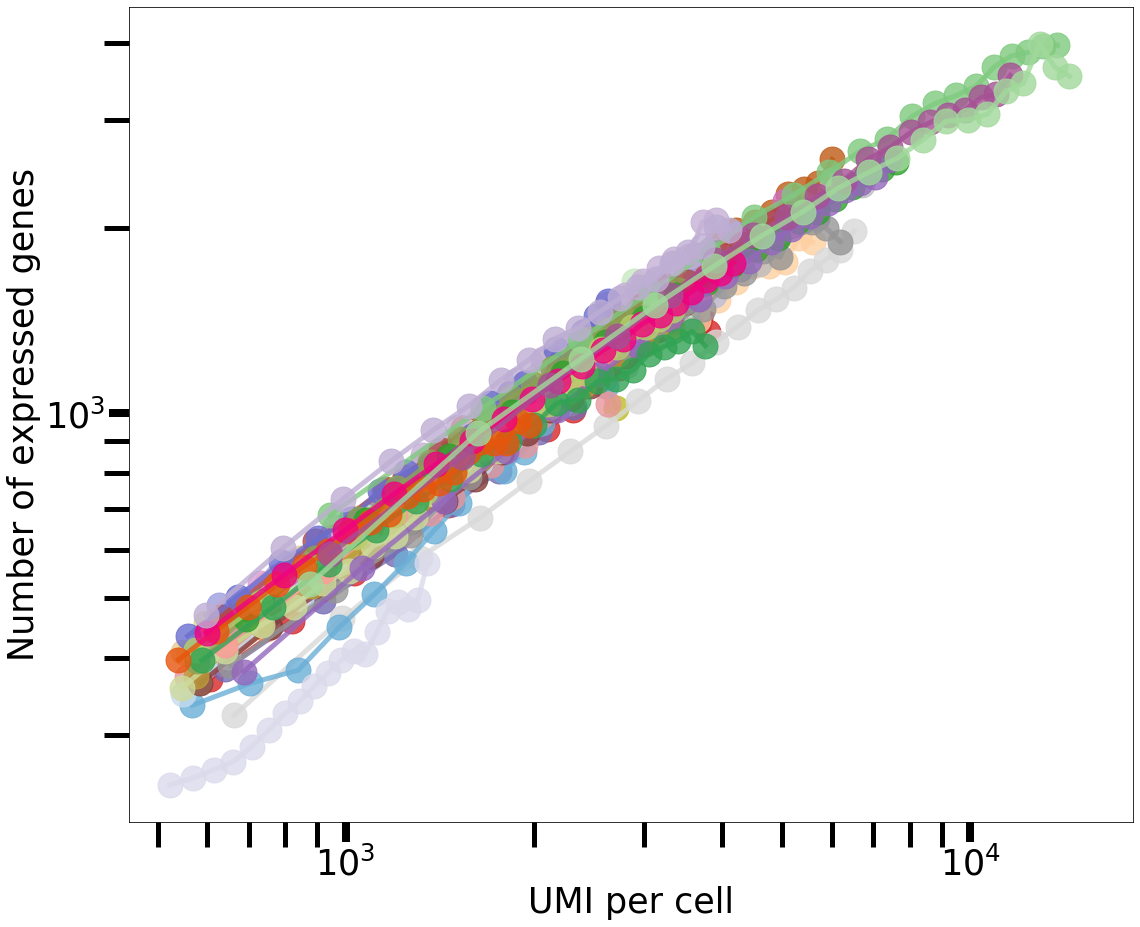

In [19]:
loglog = True
filter_mammaryLactation = True

fig, ax = plt.subplots(figsize=(18,15))
for tissue in data["frac_of"].keys():
    try:
        info = load_tissue(tissue, data_source=data_source)
    except:
        print(*sys.exc_info())
        continue
    if ("Lactation" in tissue) and filter_mammaryLactation:
        continue
    M = info["M"]
    diff= info["diffWords"]
    skip_bins = 15
    n_bins=35
    if len(M) <= n_bins:
        continue
    bin_means, bin_edges, binnumber = stats.binned_statistic(M, diff,statistic='mean', bins=np.linspace(M.min(),max(M), n_bins))
    bin_stds, _, _ = stats.binned_statistic(M, diff,statistic='std', bins=np.linspace(M.min(),np.quantile(M, 0.9), n_bins))
    x = ((bin_edges[:-1]+bin_edges[1:])/2.)[:-skip_bins]
    y = bin_means[:-skip_bins]
    ax.plot(x, y, marker='o', lw=5, ms=25, alpha=0.8, c=get_color(tissue), label=tissue)
    #ax.errorbar(x,y , bin_stds[:-skip_bins], fmt='none', ecolor='orange', elinewidth=3)

if "mca" in data_source:
    ax.set_xlabel("UMI per cell", fontsize=35)
else:
    ax.set_xlabel("Reads per cell", fontsize=35)
ax.set_ylabel("Number of expressed genes", fontsize=35)

if loglog:
    ax.set_xscale('log')
    ax.set_yscale('log')
ax.set_xlim(450,max(data["M"])*0.7) #min UMI is 500

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=25)


    
# Shrink current axis by 20%
box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, ncol=2)

plt.show()
fig.savefig("heaps_alltissues%s_mca%s.pdf"%("" if filter_mammaryLactation else "_noLactation","_loglog" if loglog else ""))

# Scaling

## CV2

In [23]:
# filter data
var = data["var"].dropna()
means = data["means"].dropna()
O = data["O"].dropna()
O = O[~O.duplicated()]
means = means[~means.duplicated()]
var = var[~var.duplicated()]
means = means[var[var>1e-7].index].dropna()
var = var.reindex_like(means)
O = O.reindex_like(means)

Use the following cell to select only coding or non-coding genes in GTEx.
**(C)** and **(D)** figures of the panel

In [ ]:
df_genes=pd.read_csv("genes_gtex.txt", header=0, index_col=0)
df_genes.head()
nc=df_genes[df_genes["type_of_gene"]!="protein-coding"].index
pc=df_genes[df_genes["type_of_gene"]=="protein-coding"].index
genelist = pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()
pc=pc[pc.isin(genelist)]

In [ ]:
#select protein coding or noncoding
means = means[means.index.isin(pc)]
var = var.reindex_like(means)

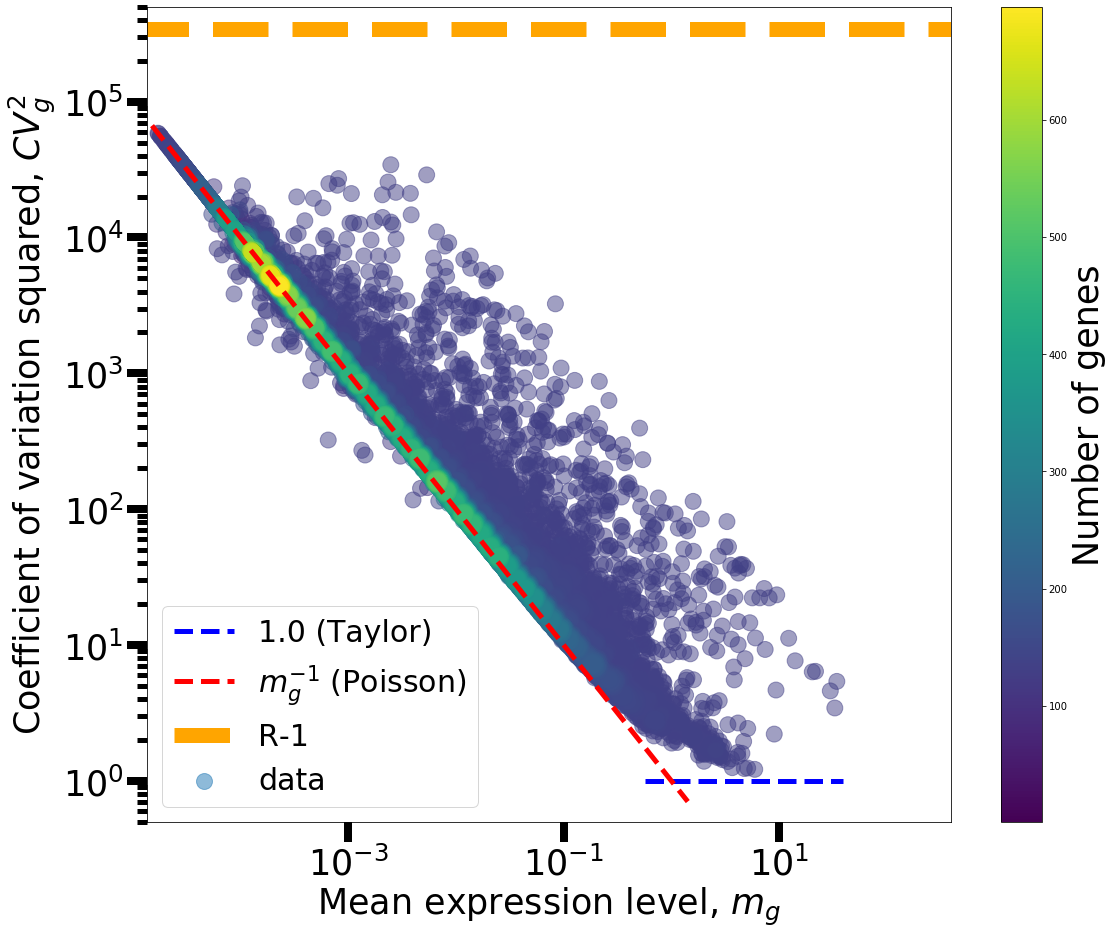

In [24]:
fig, ax = plt.subplots(figsize=(18,15))
ax.set_xlim(1e-3, 5e2)

#in GTex poisson_limit is 10
plotcv2mean(means.values.ravel(), var.values.ravel(), ax=ax, normalisation_str='counts', poisson_limit=1, alpha=0.5, s=255, colorbar=True)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(axis="both", which="minor", width=5, length=10)

upbound = len(data["M"])-1
x = np.logspace(-5,7)
ax.plot(x,[upbound for _ in x], ls="--", lw=15, c="orange", label="R-1")

ax.legend(fontsize=30)
ax.set_ylim(5e-1,5e5)
plt.show()
fig.savefig(f"cv2_mean_dense_{data_source}.pdf")

# Zipf of 100 single cell

In [26]:
df = pd.read_csv("mca/mainTable_Bone-Marrow_c-kit.csv", header=0, index_col=0)
M = df.sum(0)

In [27]:
top100 = M.sort_values(ascending=False).index[:100].values

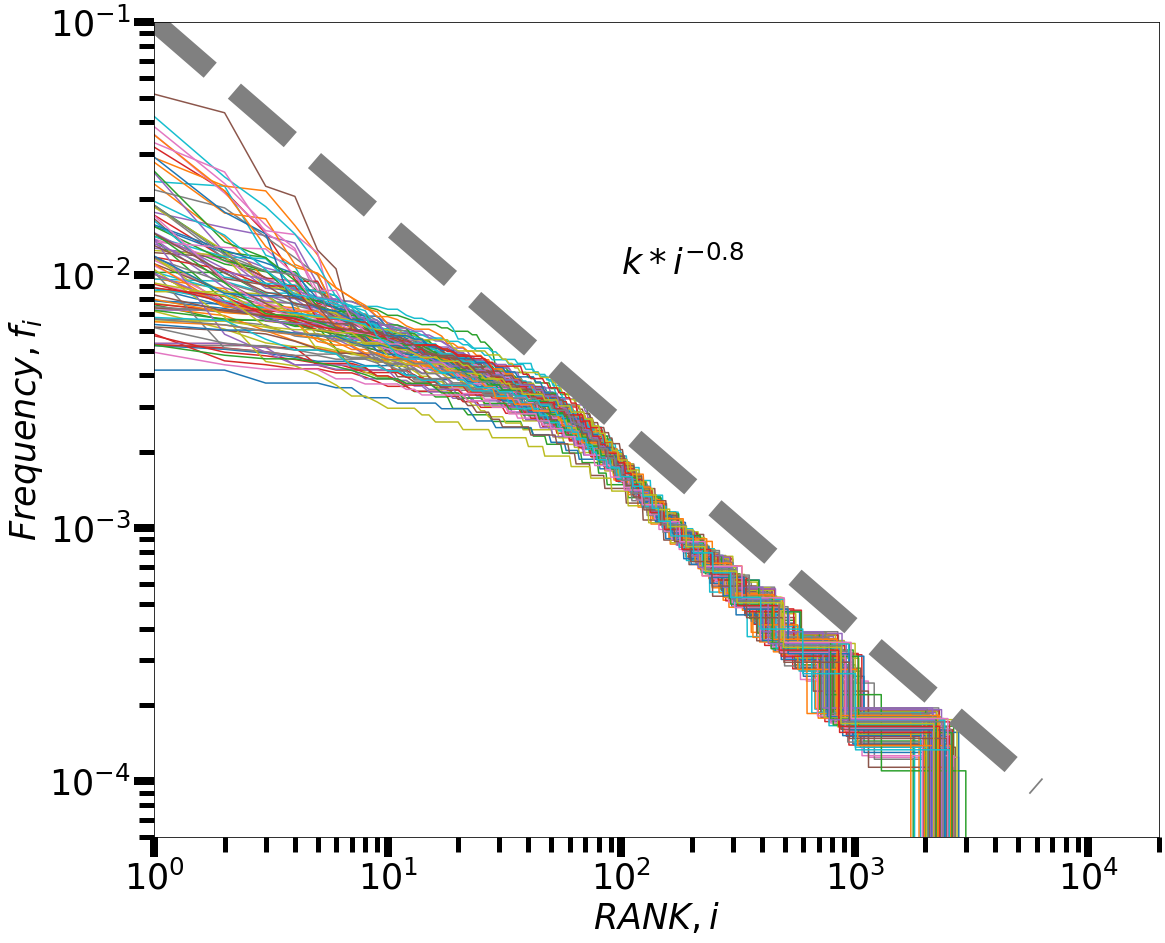

In [28]:
fig, ax = plt.subplots(figsize=(18,15))
df[df.columns[df.columns.isin(top100)]].apply(lambda x: ax.plot((x.sort_values(ascending=False)/x.sum()).values), axis=0)

x =np.linspace(1,6e3,10)

exp = 0.8
ax.plot(x, 1e-1*np.power(x, -0.8), lw=20, c='gray', ls='--')
ax.annotate('$k*i^{-%.1f}$'%exp, (1e2,1e-2), fontsize=35)


ax.set_ylabel("$Frequency, f_i$", fontsize=35)
ax.set_xlabel("$RANK, i$", fontsize=35)

ax.set_xscale("log")
ax.set_yscale("log")

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", width=5, length=15)


ax.set_xlim(1,2e4)
ax.set_ylim(6e-5,1e-1)

plt.show()
fig.savefig("zipf_top100_mca.pdf")

# Load data
Use the following cells to reload already analysed data for a given tissue

In [ ]:
tissue = "Bone-Marrow_c-Kit"

try:
    data = load_tissue(tissue, "mazzolini")

    means_null = data['means']
    var_null = data['var']
    f_null = data['freq']
    O_null = data['O']
    M_null = data["M"]
    cv2_null = data['cv2']
    diffWords_null = data['diffWords']
    means_nozero_null = data['means_nonzero']
except:
    print(*sys.exc_info())
    
data = load_tissue(tissue, "data")

means = data['means']
var = data['var']
f = data['freq']
O = data['O']
M = data["M"]
cv2 = data['cv2']
diffWords = data['diffWords']
means_nozero = data['means_nonzero']